![](https://cdn.mobilesyrup.com/wp-content/uploads/2022/01/wordle.png)

#  Wordle - An Analysis of the Internet's New Favorite Game

[Wordle](https://www.nytimes.com/games/wordle/index.html) has taken the internet by storm. What started off as a fun project to keep one entertained during the pandemic has quickly skyrocketed into a major addiction for many people. This simple word-based guessing game in which you get six chances to guess the right five-letter word has got everyone thinking about the "correct" or "optimized" strategy for success. There have been countless in-depth studies on the game already, alot of which were heavily inspired by 3Blue1Brown's amazing [Youtube](https://www.youtube.com/watch?v=v68zYyaEmEA) [videos](https://www.youtube.com/watch?v=fRed0Xmc2Wg) on the topic where he discusses how he used [Information Theory](https://en.wikipedia.org/wiki/Information_theory#:~:text=Information%20theory%20is%20the%20scientific,Claude%20Shannon%20in%20the%201940s) to help figure out the best opening guess. I was certainly inspired by that video, as well as [several](https://markmliu.medium.com/what-in-the-wordle-5dc5ed94fe2) [other](https://towardsdatascience.com/optimal-wordle-d8c2f2805704) [analyses](https://www.r-bloggers.com/2022/02/wordle-data-analysis/) [I](https://withoutbullshit.com/blog/wordle-revised-mathematical-analysis-of-the-first-guess) came across.

I decided to try to make my on analysis - both out of curiosity and a need for practicing data analysis skills. It was also quite helpful to have so many other anaylses available so that I could cross-reference my results and see if I was getting similar answers. Instead of trying to build a program that will simulate thousands of games (and thus remove *some* of the fun from the game), I have decided to do a more simple analysis on the words used in the game.

## Project Goals

My goals for this project include the following:

* Create a way to automatically scrape the Wordle website and extract the word lists
* Create aesthetically pleasing visualizations for things such as frequency or distribution of letters, etc.
* Explore any possible correlation between individual letters and their positioning in the target word
* Find the most common first letter, as well as the most common follow-up letter

# Import Libraries & Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import math
import re
import os
import json
from os.path import exists
from tqdm import tqdm
from scipy.stats import entropy
from itertools import product
from bs4 import BeautifulSoup
from matplotlib import gridspec
from IPython.display import display, Math, Latex
from heapq import nlargest
from collections import Counter

# Constants & Important Variables

In [2]:
#get path to project directory
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__"))
)

#important files & variables
PATTERN_MATRIX_FILE = os.path.join(DATA_DIR, "pattern_matrix.csv")
ANSWERS_MATRIX_FILE = os.path.join(DATA_DIR, "pattern_matrix_answers.csv")
GUESSES_MATRIX_FILE = os.path.join(DATA_DIR, "pattern_matrix_guesses.csv")
WORD_FREQ_MAP_FILE = os.path.join(DATA_DIR, "freq_map.json")

#243 combinations of colors (3^5) - g = green, r = gray, y = yellow
COMBINATIONS = [''.join(i) for i in product('gry', repeat = 5)]
POSITIONS = ['1st', '2nd', '3rd', '4th', '5th']
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

## Scrape Wordle Site To Extract Word Lists

It has been noted [numerous](https://www.pcworld.com/article/606109/how-to-cheat-at-wordle.html) [times](https://www.pcmag.com/how-to/want-to-up-your-wordle-game-the-winning-word-is-right-on-the-page#:~:text=In%20the%20search%20box%20that,arrow%20to%20reveal%20upcoming%20words) on the internet, but Wordle's word lists are actually embedded in the javascript file which you can access directly from the website. Instead of simply downloading the word lists that others have created, I wanted to see if I could do it on my own. I employed [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to create a webscraper that could automatically extract the javascript text. I had a difficult time trying to extract the word list directly from the javascript file, so in the end I decided to use a [regular expression](https://docs.python.org/3/library/re.html) to parse through the javascript text and get the lists that way.

Wordle actually has *two* lists of words:
* A solution list - a collection of 2,300+ words that we are trying to guess
* A guess list - a collection of 10,000+ words that are accepted as guesses, but not solutions

It's important to note that the words in the solution list do not appear in the guess list, so there's no fear of having any duplicate words in either list.

In [3]:
#scrape wordle site for javasript source
url = 'https://www.nytimes.com/games/wordle/index.html'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
js_file = soup.find_all('script', {"src":True})[0]['src']
js_url = 'https://www.nytimes.com/games/wordle/' + js_file

#javascript soup
js_r = requests.get(js_url)
js_soup = BeautifulSoup(js_r.content, 'html.parser')

#regex to find word lists
js_str = str(js_soup)
pattern = r"(?<=mo=\[)(.*)(?=\],fo)"  #solutions
pattern2 = r"(?<=fo=\[)(.*)(?=\],yo)" #accepted guesses
answers_regex = re.findall(pattern, js_str)
guesses_regex = re.findall(pattern2, js_str)

#flatten & sort "answers" list
answers_2d = [word.replace('"','').split(',') for word in answers_regex]
answers = [item for sublist in answers_2d for item in sublist]
answers = [word.upper() for word in answers]
answers.sort()

#flatten & sort "guesses" list
guesses_2d = [word.replace('"','').split(',') for word in guesses_regex]
guesses = [item for sublist in guesses_2d for item in sublist]
guesses = [word.upper() for word in guesses]
guesses = guesses
guesses.sort()

#collection of ALL words
total_words = guesses + answers
total_words.remove('KORAN') #causes issues with freq_map.json file down the road
total_words.remove('QURAN')

NUM_GUESSES = len(guesses)
NUM_ANSWERS = len(answers)
NUM_TOTAL   = len(total_words)

print(f'# of Answers: {NUM_ANSWERS}')
print(f'# of Possible Guesses: {NUM_GUESSES}')
print(f'Total # of Words: {NUM_TOTAL}')

# of Answers: 2309
# of Possible Guesses: 10665
Total # of Words: 12972


# Data Analysis

We can see from above that our list of possible answers contains 2,309 words, and our list of accepted guesses contains 10,665 words. Let's start by creating some helper functions to do the heavy lifting for us. The following will be functions that will help us figure out letter distributions, filter out certain letters, get letter frequencies, and plot/visualize the data.

## Helper Functions

In [4]:
#count number of times a letter shows up in given word list
def get_counts(data):
    counts = {}
    for word in data:
        for c in word:
            if c in counts:
                counts[c] += 1
            else:
                counts[c] = 1
    return counts

#filter out vowels/consonants
def filter_letters(data, vowel=False):
    filtered_counts = {}
    
    vowels = 'AEIOU'
    vowels = set(vowels)
    
    if vowel:
        for c in data:
            if c in vowels:
                filtered_counts[c] = data[c]
    else:
        for c in data:
            if c not in vowels:
                filtered_counts[c] = data[c]

    return filtered_counts
            
#calculates letter frequency for given letter position
def freq_count(data, pos):
    freq = {}
    
    #initialize every value to 0
    for letter in ALPHABET:
        freq[letter] = 0
    
    #calculate frequency table
    for word in data:
        word = word.upper()
        if word[pos] in freq:
            freq[word[pos]] += 1
        else:
            freq[word[pos]] = 1

    return freq

#calculates letter counts for given position
def get_letter_pos_counts():
    letter_pos_ans_counts = {}
    letter_pos_gue_counts = {}

    for i in range(5):
        letter_pos_ans_counts[i] = freq_count(answers, i)
        letter_pos_gue_counts[i] = freq_count(guesses, i)
        
    return letter_pos_ans_counts, letter_pos_gue_counts

#adds text labels - might remove
def addlabels(x,y):
    plt.text(x, y, y, ha = 'center', fontsize=10)

#plot bar graph showing letter distributions for word set
def plot_letter_dist(dic, title):
    #figure details
    fig, ax = plt.subplots(1,2,figsize=(15,8))
    fig.tight_layout()
    fig.suptitle(t=f'Distribution of {title}', va='bottom', fontsize=28)
        
    #plot1
    for i in sorted(dic.items()):
        ax[0].bar(i[0], dic[i[0]])
        # addlabels(i[0], i[1])

    #plot2
    for i in sorted(dic.items(), key = lambda x: x[1], reverse = True):
        ax[1].bar(i[0], i[1])
        # addlabels(i[0], i[1])
    
    #styling
    ax[0].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    ax[1].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    plt.show()

#plot letter distributions for both word lists
def plot_letter_dist_both(answers, guesses, title='Total Letter'):
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    fig.suptitle(f'{title} Distributions', fontsize=28)
    
    #subfigure details
    subfigs = fig.subfigures(nrows=1, ncols=2)
    subfigs[0].suptitle('Answers', fontsize = 24)
    subfigs[1].suptitle('Guesses', fontsize = 24)
    
    #loop for both plots
    for i in range(2):
        ax = subfigs[i].add_subplot(1,1,1)
        ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
        
        if i == 0: #answers
            for i in sorted(answers.items(), key = lambda x: x[1], reverse = True):
                ax.bar(i[0], i[1])
        else: #guesses
            for i in sorted(guesses.items(), key = lambda x: x[1], reverse = True):
                ax.bar(i[0], guesses[i[0]])
    
    plt.show()
    
#plot letter distributions for a given letter position
def plot_letter_pos_dist(answers, guesses, title='for Each Position'):
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(15,14))
    fig.suptitle(f'Letter Distributions {title}', fontsize=28)
    
    titles = ['1st', '2nd', '3rd', '4th', '5th']
    
    #subfigure details
    subfigs = fig.subfigures(nrows=5, ncols=2)
    for row, subfig in enumerate(subfigs):
        subfig[0].suptitle(f'Answers - {titles[row]}', fontsize=24)
        subfig[1].suptitle(f'Guesses - {titles[row]}', fontsize=24)
    
    #loop for both plots
    for i in range(5):
        for j in range(2):
            ax = subfigs[i][j].add_subplot(1,1,1)
            ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
            if j == 0: #answers
                for k in sorted(answers[i].items(), key = lambda x: x[1], reverse = True):
                    ax.bar(k[0], k[1])
            else: #guesses
                for k in sorted(guesses[i].items(), key = lambda x: x[1], reverse = True):
                    ax.bar(k[0], guesses[i][k[0]])
    
    plt.show()

## Letter Distributions

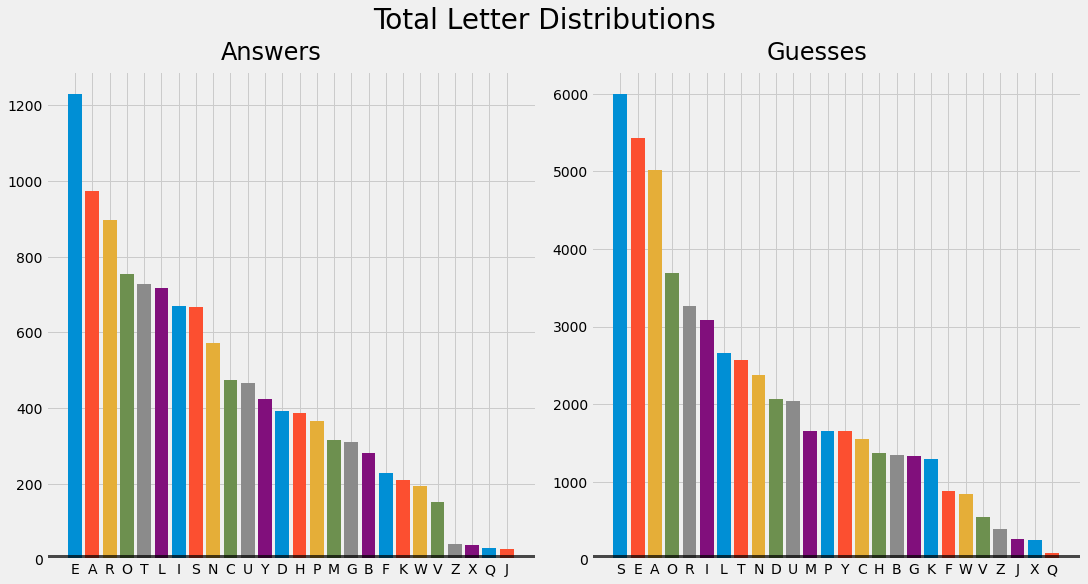

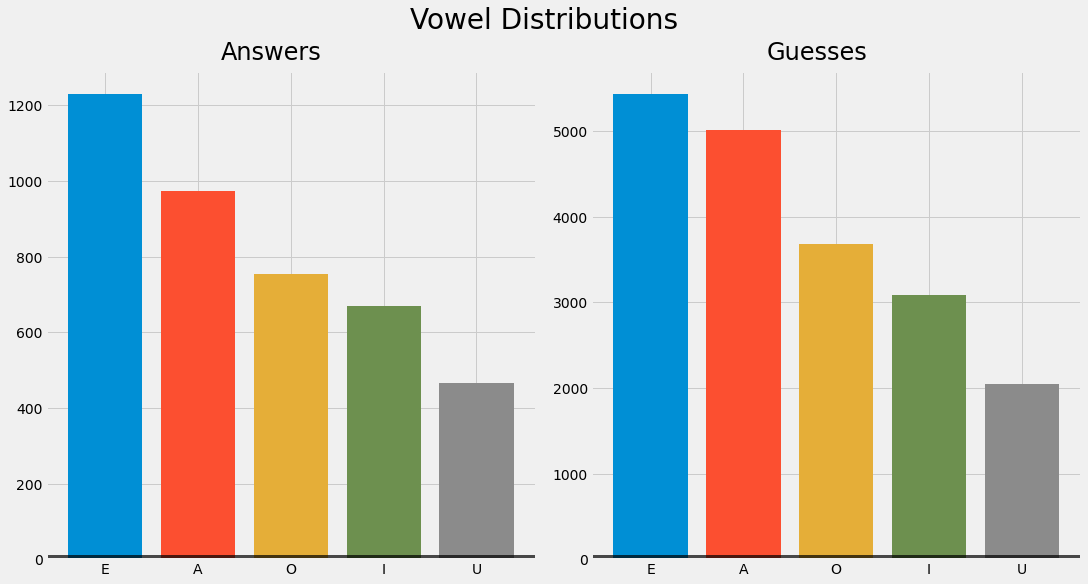

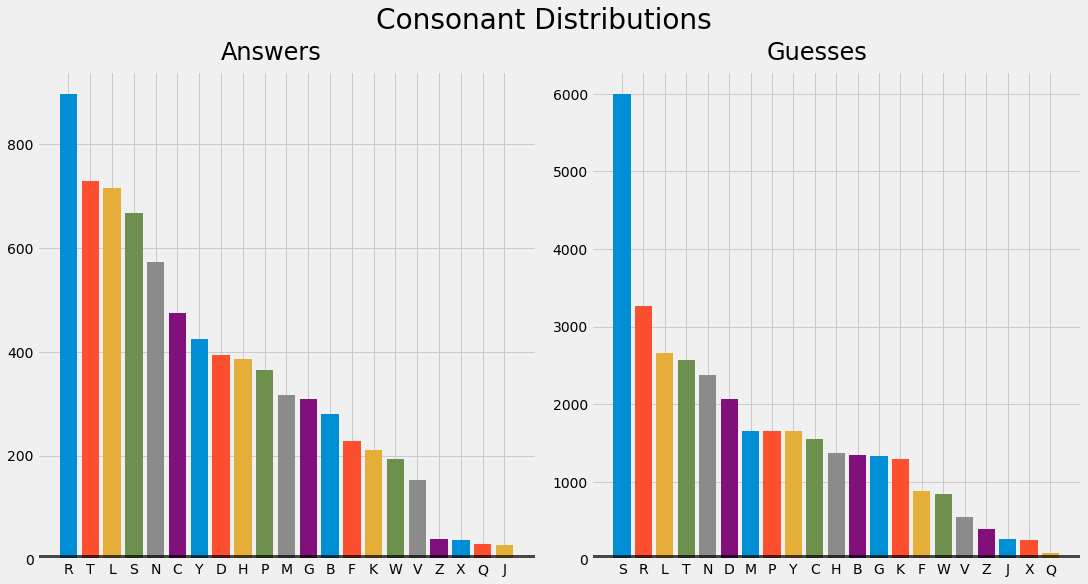

In [5]:
#gets number of times each letter shows up in words
answer_letter_counts = get_counts(answers)
guess_letter_counts = get_counts(guesses)

#get vowels-only
vowels_only_ans = filter_letters(answer_letter_counts, 1)
vowels_only_gue = filter_letters(guess_letter_counts, 1)

#get consonants-only
conson_only_ans = filter_letters(answer_letter_counts)
conson_only_gue = filter_letters(guess_letter_counts)

#plot letter distributions
plot_letter_dist_both(answer_letter_counts, guess_letter_counts)

#plot vowel distributions
plot_letter_dist_both(vowels_only_ans, vowels_only_gue, 'Vowel')

#plot consonant distributions
plot_letter_dist_both(conson_only_ans, conson_only_gue, 'Consonant')

## Observations So Far

We can see a few things from the above plot:

* **5 MOST FREQUENT LETTERS**:
    * Answers: E, A, R, O, T
    * Guesses: S, E, A, O, R  
    
* **5 LEAST FREQUENT LETTERS**:
    * Answers: V, Z, X, Q, J
    * Guesses: V, Z, X, Q, J  
        
* **5 MOST FREQUENT CONSONANTS**
    * Answers: R, T, L, S, N
    * Guesses: S, R, L, T, N  
        
Interesting points of data:
* **'S'** is the most common letter in the guess word list, but it's ranked at the **8<sup>th</sup>** most common in the answer list (**4<sup>th</sup>** if you just look at consonants).
* The vowels for both word lists have roughly the same distribution proportions.
* Any [Wheel of Fortune](https://www.wheeloffortune.com/) fans might recognize the most frequent consonants as being the same given to the contestants during the bonus round. Though it doesn't always mean you [should pick them](https://medium.com/@edweng/ohgb-beating-the-wheel-of-fortune-bonus-round-ef9f47847124#:~:text=In%201988%2C%20Wheel%20of%20Fortune,with%20the%20most%20common%20letters%3F).

## Letter Distributions for Each Position

Now that we have explored a bit about overall letter frequency and distribution, let's take a closer look at how the letter position affects the distributions.

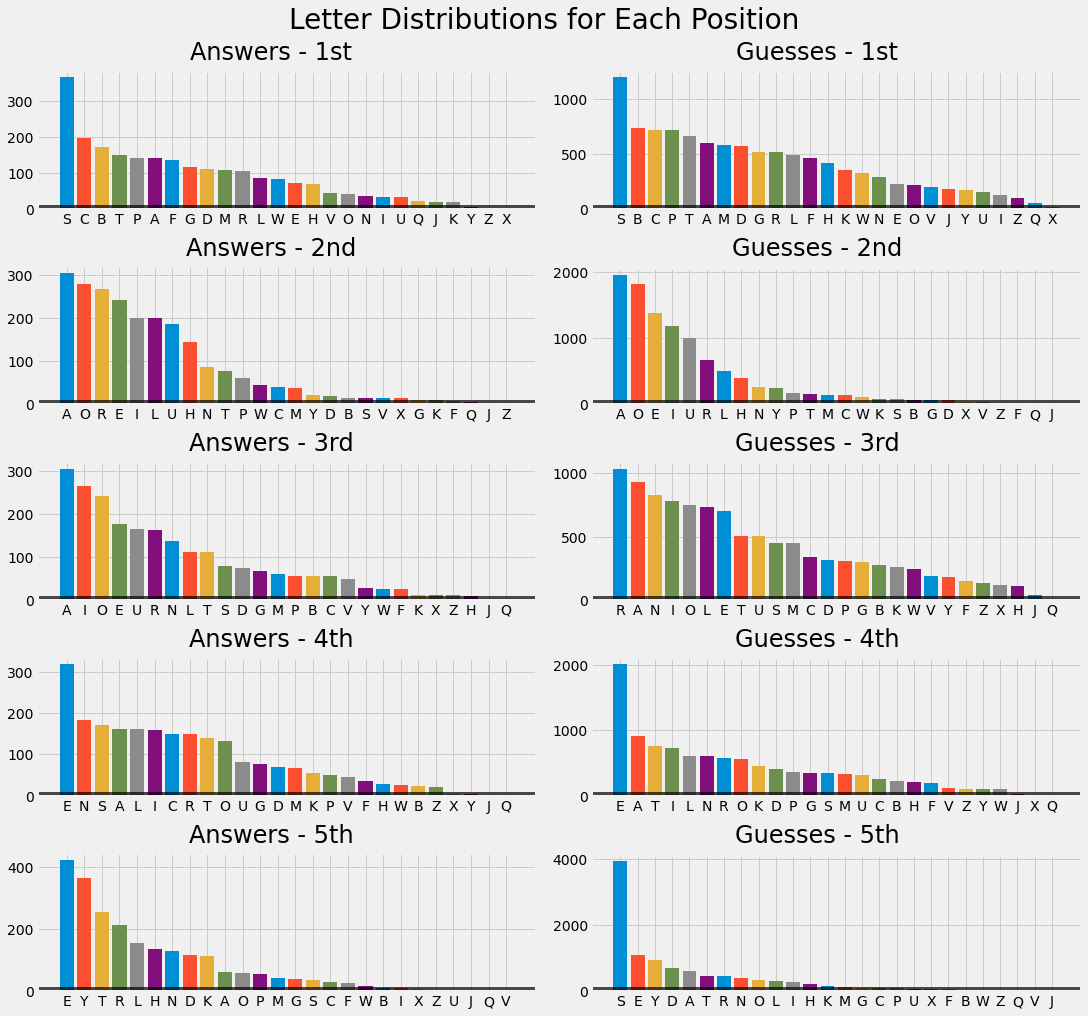

In [6]:
#gets number of times each letter shows up in given position
letter_pos_ans_counts, letter_pos_gue_counts = get_letter_pos_counts()

#plot distribution of letters for each position
plot_letter_pos_dist(letter_pos_ans_counts, letter_pos_gue_counts)

## Observations

* **5 MOST FREQUENT FIRST LETTERS**:
    * Answers: S, C, B, T, P
    * Guesses: S, B, C, P, T  
    
* **5 MOST FREQUENT LAST LETTERS**:
    * Answers: E, Y, T, R, L
    * Guesses: S, E, Y, D, A  
    
Interesting points of data:

* For both word lists, **'S'** is the most common first letter by a pretty large margin, almost double that of the next most common letter.
* For the guess word list, **'S'** is the most common first *AND* last letter, however for our answer word list, **'S'** ranks as the **15<sup>th</sup>** most common last letter!
* **'S'** is *by far* the most common last letter in our guess list - roughly 4x as likely to appear than the next most common last letter, **'E'**. Very interesting!

## Why Don't More Answer Words End In **'S'**?

Let's create a quick function to help us get a list of words with a given letter in a given position. In the case of our question, we'd like to know the words that have the letter **'S'** in the 5<sup>th</sup> position.

In [7]:
#display list of words with given letter at given position
def get_list_with_pos(pos, letter, data):
    sup = ['st', 'nd', 'rd', 'th', 'th']
        
    results = [x for x in data if x[pos-1] == letter]
    print(f'Words with \'{letter}\' in the {pos}{sup[pos-1]} position: {len(results)} ({round(len(results)/len(data)*100,2)}%)')
    return results

#get words that end with 'S'
s_answers = get_list_with_pos(5, 'S', answers)
s_guesses = get_list_with_pos(5, 'S', guesses)
print(f'\nAnswers: {s_answers}')
print(f'\nGuesses: {s_guesses[:len(s_answers)]}')

Words with 'S' in the 5th position: 36 (1.56%)
Words with 'S' in the 5th position: 3922 (36.77%)

Answers: ['ABYSS', 'AMASS', 'AMISS', 'BASIS', 'BLESS', 'BLISS', 'BONUS', 'BRASS', 'CHAOS', 'CHESS', 'CLASS', 'CRASS', 'CRESS', 'CROSS', 'DRESS', 'DROSS', 'ETHOS', 'FETUS', 'FICUS', 'FLOSS', 'FOCUS', 'GLASS', 'GLOSS', 'GRASS', 'GROSS', 'GUESS', 'HUMUS', 'LOCUS', 'LUPUS', 'MINUS', 'MUCUS', 'PRESS', 'REBUS', 'TORUS', 'TRUSS', 'VIRUS']

Guesses: ['ABACS', 'ABBAS', 'ABBES', 'ABERS', 'ABETS', 'ABIES', 'ABLES', 'ABRIS', 'ABUTS', 'ABYES', 'ACAIS', 'ACCAS', 'ACERS', 'ACHES', 'ACIDS', 'ACMES', 'ACNES', 'ACRES', 'ACROS', 'ACYLS', 'ADAWS', 'ADAYS', 'ADIOS', 'ADITS', 'ADZES', 'AEDES', 'AEGIS', 'AEONS', 'AEROS', 'AFARS', 'AFROS', 'AGARS', 'AGERS', 'AGHAS', 'AGIOS', 'AGLUS']


Right away we can see that almost **37%** of the guess words end in an **'S'**, while only **1.5%** of our answer words end in **'S'**! By examining the words from our answer list, we can see a very interesting characteristic: **none of the answer words are plurals!** (At least, no plurals that end with **'S'**.) However, if we look at a slice of our guess words, we can easily see that **this list contains plurals!** It suffices to say that the answer word list is curated to some degree. In addition, by examining the two result lists above we can see that the guess word list contains *many* uncommon (and for most people, probably unknown) words. We will get a little more in-depth with that later.

## Letter Probabilities & Correlations

Now let's look at what the odds are of having a given letter in a given position. We'll create some functions to help calculate this information, as well as function to help us plot a heatmap so we can get a better visualization of what our information means.

In [8]:
#calculate probability for given letter in each position
def get_letter_prob(letter):
    a_letters = []
    g_letters = []
    
    for i in range(5):
        a_letters.append(letter_pos_ans_counts[i][letter] / NUM_ANSWERS)    
        g_letters.append(letter_pos_gue_counts[i][letter] / NUM_GUESSES)
    
    return a_letters, g_letters

#create df of probabilities for each letter in each position
def get_letter_prob_df():
    #initialize dataframe
    a_letters = pd.DataFrame(columns = POSITIONS,
                           index=sorted(answer_letter_counts.keys()))
    g_letters = pd.DataFrame(columns = POSITIONS,
                           index=sorted(guess_letter_counts.keys()))

    #loop through alphabet and get probability
    for i in range(26):
        a_probs, g_probs = get_letter_prob(ALPHABET[i])
        for j in range(5):
            a_letters.iloc[i,j] = a_probs[j]
            g_letters.iloc[i,j] = g_probs[j]

    #convert to float for use with heatmap
    a_letters = a_letters.astype('float')
    g_letters = g_letters.astype('float')
    
    return a_letters, g_letters

def plot_heatmap(data1, data2, horizontal=False):
    if horizontal:
        data1 = data1.T
        data2 = data2.T
        orientation = 'horizontal'
        shrink = 0.9
        pad = 0.15
        fig_h = 8
        title = 'Letter-Position Probability Heatmap'
    else:
        data1 = data1.corr()
        data2 = data2.corr()
        orientation = 'horizontal'
        shrink = 0.45
        pad = 0.05
        fig_h = 10
        title = 'Letter-Position Correlation Heatmap'
        
    if data1.shape[0] == data1.shape[1]:
        mask = np.zeros_like(data1, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = False
        
    #figure details
    fig = plt.figure(figsize=(16,fig_h))
    fig.tight_layout()
    fig.suptitle(title, y=1.06, fontsize=28)
    
    #subfigure details
    if horizontal:
        subfigs = fig.subfigures(nrows=2, ncols=1)
    else:
        subfigs = fig.subfigures(nrows=1, ncols=2)
        
    subfigs[0].suptitle(f'Answers', fontsize=24, va='top')
    subfigs[1].suptitle(f'Guesses', fontsize=24, va='top')
    
    #plot details
    if horizontal:
        ax1 = subfigs[0].add_subplot(1,1,1)        
        ax1 = sns.heatmap(data1, square=True, cmap='viridis', cbar_kws={'shrink': shrink, 'orientation': orientation, 'pad': pad})
                
        ax2 = subfigs[1].add_subplot(1,1,1)
        ax2 = sns.heatmap(data2, square=True, cmap='viridis', cbar_kws={'shrink': shrink, 'orientation': orientation, 'pad': pad})
    else:
        ax1 = subfigs[0].add_subplot(1,1,1)        
        ax1 = sns.heatmap(data1, square=True, mask=mask, cmap='viridis', cbar_kws={'shrink': shrink, 'orientation': orientation, 'pad': pad})
        
        ax2 = subfigs[1].add_subplot(1,1,1)
        ax2 = sns.heatmap(data2, square=True, mask=mask, cmap='viridis', cbar_kws={'shrink': shrink, 'orientation': orientation, 'pad': pad})
       
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation = 0, fontsize = 16)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 0, fontsize = 16)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation = 0, fontsize = 16)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 0, fontsize = 16)
    plt.show()

#create dataframes with letter probabilities
a_letters, g_letters = get_letter_prob_df()

In [9]:
a_letters.head()

,1st,2nd,3rd,4th,5th
A,0.060632,0.131659,0.132525,0.070160,0.027285
B,0.074924,0.006929,0.024253,0.010394,0.004764
C,0.085751,0.017324,0.024253,0.064963,0.013426
D,0.048073,0.008662,0.032482,0.029883,0.051104
E,0.031182,0.104374,0.076657,0.137722,0.182763


In [10]:
g_letters.head()

,1st,2nd,3rd,4th,5th
A,0.055977,0.183685,0.087201,0.085701,0.057853
B,0.069011,0.006095,0.026160,0.020534,0.004501
C,0.067886,0.012752,0.031505,0.024473,0.009001
D,0.053821,0.006001,0.029536,0.037693,0.066104
E,0.021660,0.130052,0.066104,0.188373,0.103141


We can see from the above two dataframes that we have five columns (one for each letter position) along with the probabilities for each letter to show up in that position. It's a little difficult to make sense of a screen full of float numbers like that, so we can try to visualize our dataframes in a slightly easier format.

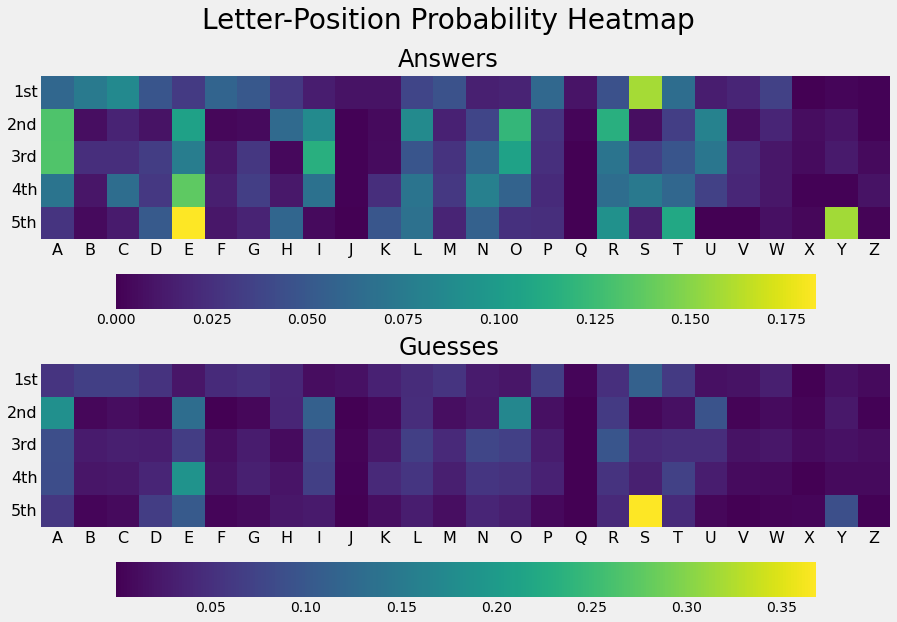

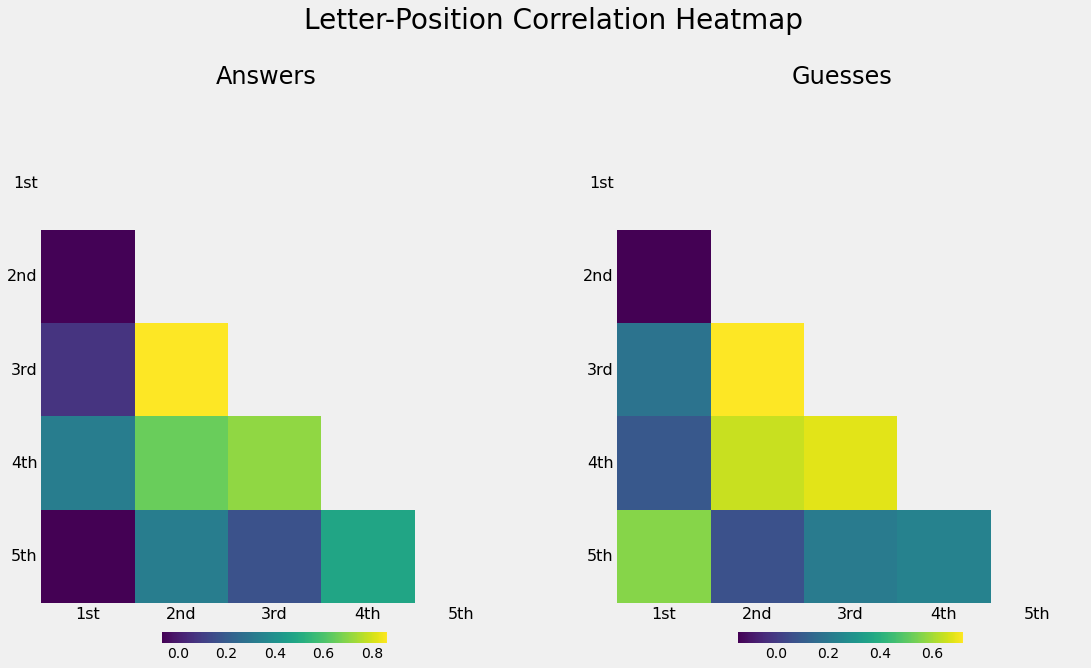

In [11]:
#plot heatmaps
plot_heatmap(a_letters, g_letters, 1)
plot_heatmap(a_letters, g_letters, 0)

## Observations

For letter probabilities:  
**ANSWERS**:
* Higher probability of the word ending in **'E'** or **'Y'**.
* Higher probability of the word starting in **'S'**.
* The **2<sup>nd</sup>** and **3<sup>rd</sup>** letters have a relatively higher probability of being a **vowel**.
* The probabilities are more evenly distributed amongst our ANSWER words compared to the GUESSES set.  

**GUESSES**:
* No real stand-out letter for the first position.
* Much higher probability of the word ending in **'S'**.
* The fourth letter has a high probability of being an **'E'**.
* The **2<sup>nd</sup>** letter has a relatively higher probability of being a **vowel**.
* The probabilities are very not evenly distributed - only a couple of higher-probability values.  

For letter-position correlation:  
**ANSWERS**:
* It seems like there is a fairly strong correlation between the **2<sup>nd</sup>** and **3<sup>rd</sup>** letters.
* There's also a strong correlation bewteen the **3<sup>rd</sup>** and **4<sup>th</sup>**.

**GUESSES**:  
* There are strong correlations between the **2<sup>nd</sup>**, **3<sup>rd</sup>** and **4<sup>th</sup>** letters repsectively.
* Interestingly, we see a correlation between the **1<sup>st</sup>** and **5<sup>th</sup>** letters that was not present in our ANSWERS.

## So What Does It Mean?

Using all of our probabilities to plot a heatmap can help us get a better idea of how often we may see a letter. There are clearly stark differences in the probabilities and corrrelations between our answers and our guesses word lists. This makes me believe that *the answer words are not just chosen at random*. In fact this, paired with our discovery regarding plural words, allows me to more confidently say that the answer words have been carefully picked instead of being chosen from the total possible guesses. It wouldn't be a very fun game if every answer was a word that nobody knew, so the curator of the answers probably has to filter out the obscure, unknown words so that only commonly used words could be answers. More on that later.

# Understanding Information & Entropy

What is *information* and what does it mean? In [Information Theory](https://en.wikipedia.org/wiki/Information_theory), the term *information* refers to the amount of "stuff" in a given message. In the case of our Wordle Analysis, information refers to the probability of our 5 letters being in a certain pattern. The more common an event is, the less information it contains. Conversely, the more rare an event is, the more information it contains. We can measure information in **[bits](https://cs.stanford.edu/people/eroberts/courses/soco/projects/1999-00/information-theory/bits_and_binary_digits_3.html)**. When you can remove half of the possible outcomes from an observation, we say that that observation contains 1.0 bit of information. The intuition would follow that a single bit represents 1 of 2 outcomes (or distributions of outcomes).

How about *entropy*? Entropy is simply the amount of *expected* information needed to represent a given event. Another way to look at it is that entropy is the *amount of surprise* in an event. The higher the probability of an event happening, the less information gained by it, which means less surprise, which results in a lower entropy. The lower the probability of an event means that more information can be gained by it, which means more surprise, which results in a higher entropy.

There are entire branches of mathematics dedicated to this topic, and it can get extremely confusing really fast. There are [many](https://towardsdatascience.com/the-intuition-behind-shannons-entropy-e74820fe9800) [good](https://machinelearningmastery.com/what-is-information-entropy/) [explanations](https://towardsdatascience.com/information-entropy-c037a90de58f) [available](https://en.wikipedia.org/wiki/Entropy_(information_theory)) online, all of which I needed before I could really wrap my head around it.

We're going to create some more functions to help calculate probability, information gain, and entropy for every word. In order to calculate entropy, we need to first calculate the probability that a word will result in a given pattern for every possible combination of patterns ("pattern" in our case would mean the colors of the tiles after you make a guess). We will generate a pattern matrix - a huge dataframe that contains 12,972 rows (one for each word), and 243 columns (3<sup>5</sup> combinations). Each column is one possible combination of green, gray, and yellow tiles - represented by the letters g, r, and y.

## Helper Functions

In [12]:
#return list of guess words that have given letter in given position
def choices_inc(letter, pos, words=total_words):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if word[pos-1] == letter:
            choices.append(word)            
    return choices

#return list of guess words that contain letter NOT in given position
def choices_exc(letter, pos=0, words=total_words):
    choices = []
    if words or len(words) == 0:
        word_bank = words
    
    for word in word_bank:            
        if word[pos-1] != letter and letter in word:
            choices.append(word)   
    return choices

#return list of guess words that do NOT contain letter at all
def choices_abs_exc(letter, words=total_words):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if letter not in word:
            choices.append(word)    
    return choices

#calculates probability of given word and results
def get_probability(word, colors, data):
    word = word.upper()
    
    #list to contain lists of remaining possible matches
    pool = []
    
    #loop over each letter / color pair and compute remaining matches
    for i in range(5):
        #letter 1
        if i == 0:            
            if colors[i] == 'g': #green
                rem_set = choices_inc(word[i], i+1, data)
            elif colors[i] == 'r': #gray
                rem_set = choices_abs_exc(word[i], data)
            else: #yellow
                rem_set = choices_exc(word[i], i+1, data)
        
        #letters 2-5
        else:            
            if colors[i] == 'g':
                rem_set = choices_inc(word[i], i+1, pool[-1])
            elif colors[i] == 'r':
                rem_set = choices_abs_exc(word[i], pool[-1])
            else:
                rem_set = choices_exc(word[i], i+1, pool[-1])
        
        #adds remaining possible matches to pool
        if rem_set or len(rem_set) == 0:            
            pool.append(rem_set)

        # print(f'{word[i].upper()}, {colors[i]}, {len(rem_set)} matches left')
        
    num_matches = len(pool[-1])
    probability = num_matches / len(data)
    
    #don't return an empty list
    if pool[-1] == []:
        pool[-1] = [0]        
    return probability, pool[-1]

#calculate information gain
def get_information(prob):
    if prob == 0:
        return 0.00
    return math.log2(1/prob)

#calculate entrooy of given probabilities
def get_entropy(data):    
    distributions = pd.Series(data)
    axis = len(distributions.shape) - 1
    return entropy(distributions, base=2.0, axis=axis)

#if `in_file` doesn't exist, create it - can take 45+ minutes!
def get_pattern_matrix(words, in_file, out_file):
    if not os.path.exists(in_file):
        print(f'Generating {out_file}...')
        all_p = {}
        for word in tqdm(words):
            all_p[word] = [get_probability(word, combo, words)[0] for combo in COMBINATIONS]

        #create dataframe of all probabilities
        pattern_matrix = pd.DataFrame.from_dict(all_p, orient='index', columns=COMBINATIONS)

        #create .csv file so we don't have to re-compute every time
        pattern_matrix.to_csv(f'{out_file}.csv')
        print('Done!')
        return pattern_matrix
    
    #else if `in_file` exists, read it in to df and return
    else:
        pattern_matrix = pd.read_csv(f'{out_file}.csv', index_col=[0])
        print(f'Loading {out_file}... Done!')
        return pattern_matrix

#returns dataframe with probabilities sorted highest->lowest
def sort_prob(word, dist):
    #create temp df
    df = pd.DataFrame(columns = ['Probability'])
    df['Probability'] = dist.loc[word]    
    df.sort_values(by='Probability', ascending=False, inplace=True)    
    return df

#creates the text for annotations in a graph
def get_annot(word, xloc, df, dist):
    y = df.iloc[xloc, 0]
    text = (
        # f'Entropy = {round(get_entropy(dist.loc[word]),2)}\n'
        f'Probability = {round(df.iloc[xloc, 0],4)}\n'
        f'Information = {round(get_information(df.iloc[xloc, 0]),2)}\n'
    )
    return text

def copy_ax(ax):    
    ax.set_xlim(-2,150,1)
    ax.set_ylim(-0.0005,0.12)
    ax.set_xlabel(f'Patterns', fontsize=16)
    ax.set(ylabel=None)    
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelsize=12)
    ax.axhline(y = -0.00025, color = 'black', linewidth = 6, alpha = .7)
    return ax

def plot_pattern_distr(word, pattern, dist, data):
    #finds probability of given word with given pattern
    p = get_probability(word, pattern, data)
    print(f'Probability of [{word}] w/ [{pattern}] pattern = {round(p[0],4)}')

    #print # of matches
    print(f'Possible Matches Left = {len(p[1])}')

    #calculates information gain in bits
    i = get_information(p[0])
    print(f"Information Gained in Bits = {round(i,2)}")

    #calculate entropy
    ent = round(get_entropy(dist.loc[word]),2)
    print(f'Max Entropy - [{word}] = {ent}')
    
    EntropyFunc = r'$E[I] = \sum_{x} p(x)\log_2(1/p(x)) = $'
    
    #sorts probabilities highest -> lowest
    df = sort_prob(word, dist)
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Probability Distribution - [{word}]', fontsize=28)
    fig.tight_layout()

    #plot
    sns.barplot(x=df.index, y=df['Probability'], palette='crest')
   
    #annotation_1
    xloc1 = 0
    yloc1 = df.iloc[xloc1,0]
    text1 = get_annot(word, xloc1, df, dist)
    
    ax.annotate(f'{text1}', fontsize=16, xy=(xloc1, yloc1), xytext=(xloc1+15, yloc1*0.85), 
                arrowprops=dict(arrowstyle='simple', facecolor='black'))
        
    #annotation_2
    xloc2 = 120
    yloc2 = df.iloc[xloc2,0]        
    text2 = get_annot(word, xloc2, df, dist)
            
    ax.annotate(f'{text2}', fontsize=16, xy=(xloc2, yloc2), xytext=(xloc2-5, yloc2+(0.25*yloc1)), 
                arrowprops=dict(arrowstyle='simple', facecolor='black'))    

    #annotation_3
    xloc3 = 70
    yloc3 = yloc1 * 0.75
    text3 = EntropyFunc + str(ent)
    
    ax.annotate(f'{text3}', fontsize=22, xy=(xloc3, yloc3), xytext=(xloc3-5, yloc3)) 
    
    #plot details
    ax.set_xlim(-2,150,1)
    ax.set_xlabel(f'Patterns', fontsize=16)
    ax.set(ylabel=None)
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelsize=12)
    ax.axhline(y = -0.00025, color = 'black', linewidth = 3, alpha = .7)
    plt.show()
    
def compare_words(word1, patt1, word2, patt2, dist, data):
    #word1 calculations
    p1 = get_probability(word1, patt1, data)
    m1 = len(p1[1])
    i1 = get_information(p1[0])
    e1 = round(get_entropy(dist.loc[word1]),2)
    df1 = sort_prob(word1, dist)
    
    #word2 calculations
    p2 = get_probability(word2, patt2, data)
    m2 = len(p2[1])
    i2 = get_information(p2[0])
    e2 = round(get_entropy(dist.loc[word2]),2)
    df2 = sort_prob(word2, dist)
    
    EntropyFunc = r'$E[I] = \sum_{x} p(x)\log_2(1/p(x)) = $'
    
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(16,8))
    fig.suptitle(f'Probability, Information, and Entropy Comparison', fontsize=28)
    
    #subfigure details
    subfigs = fig.subfigures(nrows=1, ncols=2)
    subfigs[0].suptitle(f'[{word1}]', fontsize = 24)
    subfigs[1].suptitle(f'[{word2}]', fontsize = 24)
    
    #annotation location
    xloc = 30
    yloc = 0.06
    
    #left plot
    ax = subfigs[0].add_subplot(1,1,1)
    sns.barplot(x=df1.index, y=df1['Probability'], palette='crest')
    ax = copy_ax(ax)
    
    #left annotation
    text = EntropyFunc + str(e1)    
    ax.annotate(f'{text}', fontsize=22, xy=(xloc, yloc), xytext=(xloc, yloc))
    ax.annotate(f'{m1} Possible Words', fontsize=22, xy=(xloc, yloc), xytext=(xloc+15, yloc-0.01))
    
    #right plot
    ax = subfigs[1].add_subplot(1,1,1)
    sns.barplot(x=df2.index, y=df2['Probability'], palette='crest')
    ax = copy_ax(ax)
    
    #right annotation
    text = EntropyFunc + str(e2)    
    ax.annotate(f'{text}', fontsize=22, xy=(xloc, yloc), xytext=(xloc, yloc))
    ax.annotate(f'{m2} Possible Words', fontsize=22, xy=(xloc, yloc), xytext=(xloc+15, yloc-0.01))

## Example

In [13]:
# returns dataframe of ALL probabilities for EVERY combination of EVERY word - not weighted
patterns = get_pattern_matrix(total_words, PATTERN_MATRIX_FILE, 'pattern_matrix')
a_patterns = get_pattern_matrix(answers, ANSWERS_MATRIX_FILE, 'pattern_matrix_answers')
g_patterns = get_pattern_matrix(guesses, GUESSES_MATRIX_FILE, 'pattern_matrix_guesses')

#display 5 random samples to show it works
patterns.sample(n=5)

Loading pattern_matrix... Done!
Loading pattern_matrix_answers... Done!
Loading pattern_matrix_guesses... Done!


,ggggg,ggggr,ggggy,gggrg,gggrr,gggry,gggyg,gggyr,gggyy,ggrgg,...,yyryy,yyygg,yyygr,yyygy,yyyrg,yyyrr,yyyry,yyyyg,yyyyr,yyyyy
ADSUM,0.000077,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000308,0.0,0.000077,0.000000,0.000000,0.014413,0.000540,0.0,0.001619,0.000154
FRANC,0.000077,0.000077,0.000000,0.000000,0.001079,0.000154,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.001387,0.000000,0.0,0.000077,0.000000
SAMBA,0.000077,0.000000,0.000077,0.000000,0.000000,0.000848,0.0,0.0,0.0,0.000077,...,0.005627,0.0,0.000000,0.000000,0.000462,0.000000,0.005550,0.0,0.000000,0.000308
OLEIC,0.000077,0.000077,0.000000,0.000000,0.000231,0.000000,0.0,0.0,0.0,0.000000,...,0.000462,0.0,0.000540,0.000077,0.000000,0.012487,0.000925,0.0,0.000462,0.000000
GROUT,0.000077,0.000154,0.000000,0.000077,0.001310,0.000077,0.0,0.0,0.0,0.000000,...,0.000077,0.0,0.000154,0.000000,0.000000,0.002312,0.000000,0.0,0.000231,0.000000


Above we can see an example of our pattern_matrix (which we have named "patterns"). It lists each word, and every probability for every combination. In order to calculate the entropy for a given word, we will need the entire row of probabilities. We can see what our probability distribution looks like by sorting the probabilities and plotting them on a bar graph.

Probability of [SLATE] w/ [rrrrr] pattern = 0.0667
Possible Matches Left = 865
Information Gained in Bits = 3.91
Max Entropy - [SLATE] = 5.87


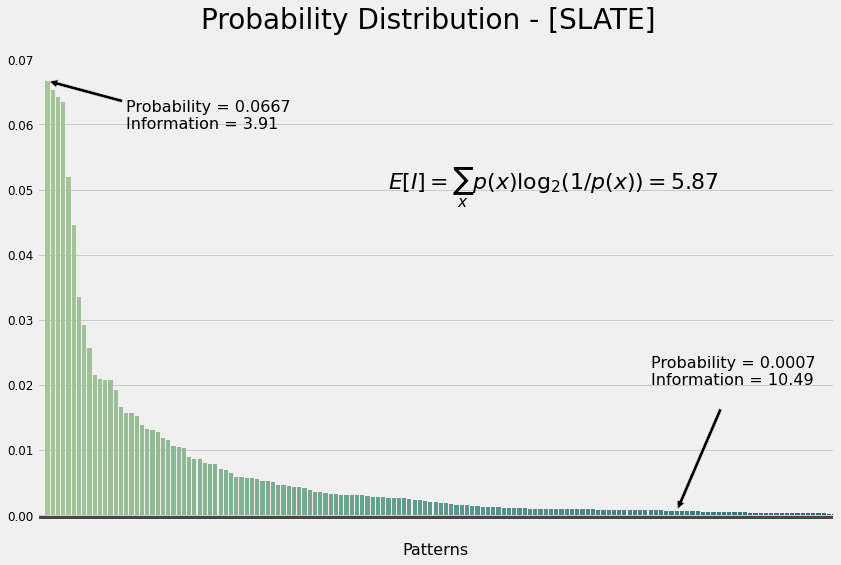

In [14]:
#picking a "test" word
find_word = 'SLATE'
find_patt = 'rrrrr'

#plot probability distribution
plot_pattern_distr(find_word, find_patt, patterns, total_words)

From the plot above, we can see that the pattern with the highest probability (in our case, all grays) has a 6.67% chance of occurring. Because it is the most likely outcome, our information gain is about 3.91 bits. This is equivalent to saying that we would have to remove half our possible outcomes roughly 4 times before getting that specific pattern. Conversely, a lower probability pattern would yield us 10.49 bits of information. This is also equivalent to saying that we would have to remove half our possible outcomes almost 11 times before we can get the specific pattern. For comparison, let's try a different word:

Probability of [WEARY] w/ [rrrrr] pattern = 0.1422
Possible Matches Left = 1844
Information Gained in Bits = 2.81
Max Entropy - [WEARY] = 4.9


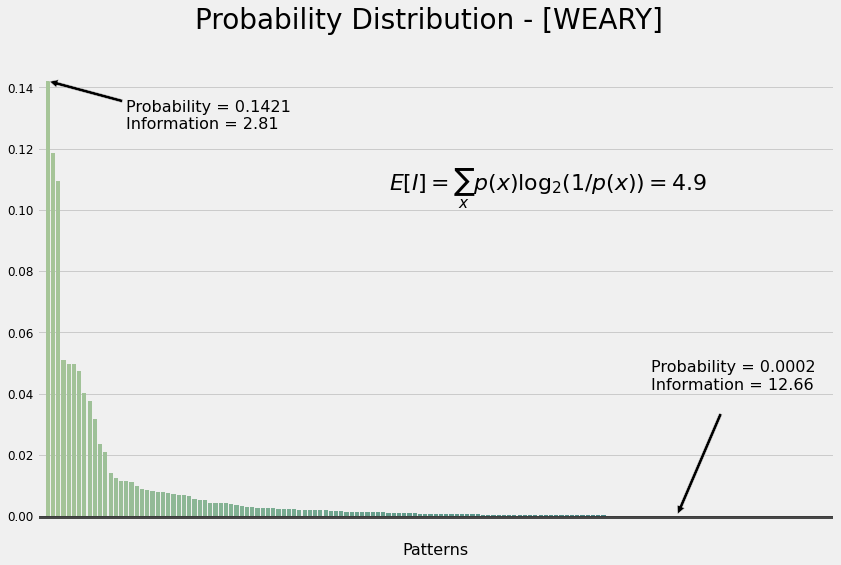

In [15]:
#picking a "test" word
find_word = 'WEARY'
find_patt = 'rrrrr'

#plot probability distribution
plot_pattern_distr(find_word, find_patt, patterns, total_words)

Here, our word was 'WEARY', and the highest probability outcome would yield 2.81 bits of information. A much lower probability outcome, though incredibly rare, would yield us 12.66 bits of information. What our entropy value represents is the minimum required number of bits to produce any single output in the given distribution of probabilities. The flatter the distribution, the less common events become, which leads to a higher entropy since we need more information to produce those events.

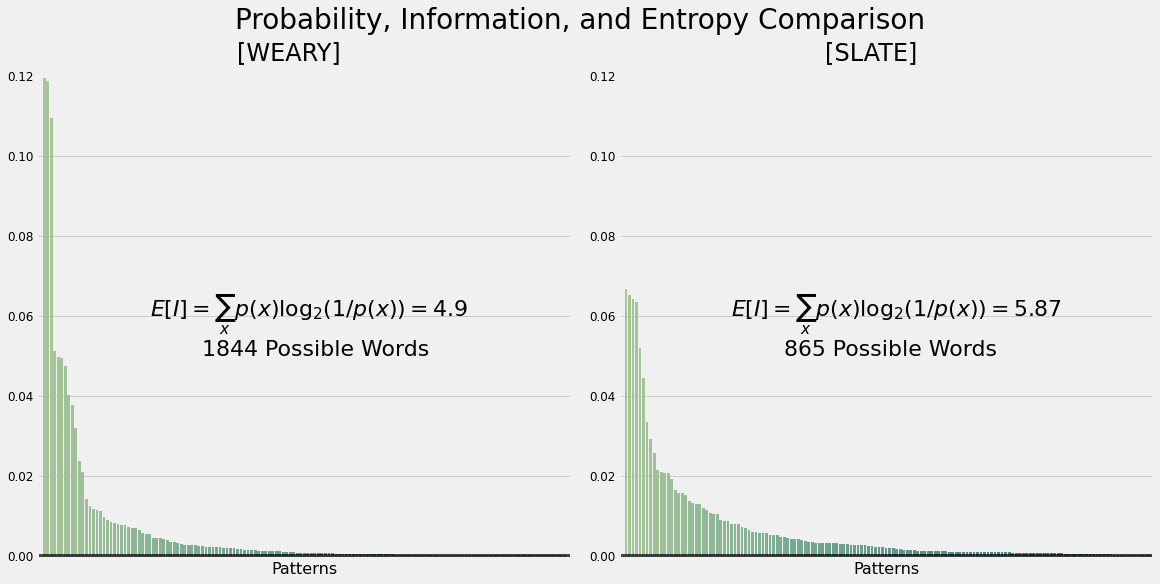

In [16]:
w1, w2 = 'WEARY', 'SLATE'
p1, p2 = 'rrrrr', 'rrrrr'
compare_words(w1, p1, w2, p2, patterns, total_words)

In the above plot, we compare the probability distributions between our two words - 'WEARY' and 'SLATE'. The distribution for 'SLATE' is flatter, and the most common outcome only has about a **6%** chance of happening, compared to 'WEARY's most common outcome, which has about a **12%** chance of happening. Since 'SLATE' has a higher entropy (by about 1 bit), this means that on average, the resulting space of possible answers will be about ***half*** as big as the space of possibile answers for 'WEARY'.

## High-Entropy Words

So based on what we've just examined, the intuition would then be to pick the word with the highest entropy as your starting word. The word with the highest entropy would remove the most number of outcomes, thus making the pool of remaining words smaller. So what are the highest-entropy words? Note that I am not saying that these words are *the best* opening words, just ones with the highest entropies. Let's create a function that will easily calculate this for us. \**It's also important to note that because Wordle uses two lists of words, you can get two different results for highest entropy. We just need to keep this in mind.\**

In [17]:
#I created these two matrix files separately using the get_pattern_matrix() function
#My original patterns contains ALL 12,974 words
answers_matrix = pd.read_csv(ANSWERS_MATRIX_FILE, index_col=[0])
guesses_matrix = pd.read_csv(GUESSES_MATRIX_FILE, index_col=[0])

def calc_entropies(data, title):
    #calculate entropy for every single word
    entropy_scores = {}
    for i in range(data.shape[0]):
        entropy_scores[data.iloc[i].name] = get_entropy(data.iloc[i])
        
    #sorts lists, converts to dictionary
    sorted_tuples = sorted(entropy_scores.items(), key = lambda x:x[1], reverse = True)
    sorted_entropies = {k: v for k, v in sorted_tuples}
    entropies = pd.Series(sorted_entropies, index=sorted_entropies.keys())
    
    #display top 10
    print(f'{title} Avg. Entropy: {round(entropies.mean(),2)}')
    print(f'TOP 10 - {title}')
    print('-----------------')
    print(entropies.head(10), '\n')
    return entropies

all_entropies = calc_entropies(patterns, 'COMBINED')
ans_entropies = calc_entropies(answers_matrix, 'ANSWERS')
gue_entropies = calc_entropies(guesses_matrix, 'GUESSES')

COMBINED Avg. Entropy: 4.54
TOP 10 - COMBINED
-----------------
TARES    6.194227
LARES    6.150100
RALES    6.114223
RATES    6.096135
TERAS    6.076902
NARES    6.067449
SOARE    6.061508
TALES    6.054744
REAIS    6.049680
TEARS    6.032243
dtype: float64 

ANSWERS Avg. Entropy: 4.51
TOP 10 - ANSWERS
-----------------
RAISE    5.878303
SLATE    5.855819
CRATE    5.835216
IRATE    5.832799
TRACE    5.830429
ARISE    5.821023
STARE    5.806889
SNARE    5.768678
AROSE    5.767805
LEAST    5.751562
dtype: float64 

GUESSES Avg. Entropy: 4.53
TOP 10 - GUESSES
-----------------
TARES    6.156943
LARES    6.129040
RALES    6.092107
RATES    6.059324
NARES    6.050810
TERAS    6.036925
TALES    6.018344
REAIS    6.016920
SOARE    6.005210
DARES    5.996602
dtype: float64 



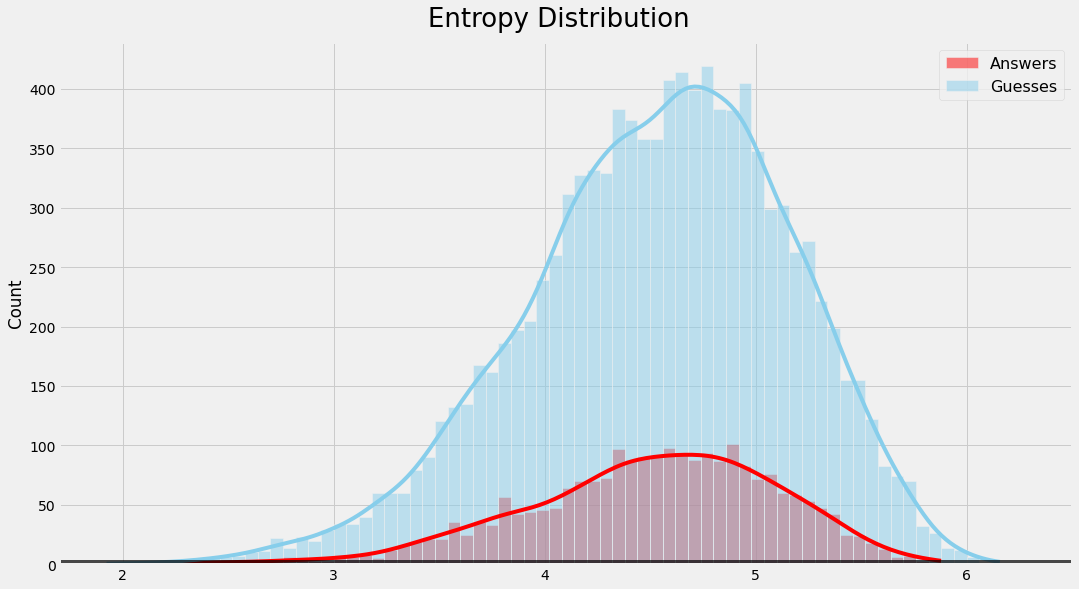

In [18]:
def plot_entropy_dist(data1, data2):
    #figure details
    fig, ax = plt.subplots(figsize=(15,8))
    fig.tight_layout()
    fig.suptitle(f'Entropy Distribution', va='bottom', fontsize=26)
        
    #plot1
    ax = sns.histplot(data1, color='red', kde=True, label='Answers', bins=np.arange(0, data1.max(), 0.06))
    ax = sns.histplot(data2, color='skyblue', kde=True, label='Guesses', bins=np.arange(0, data2.max(), 0.06))
    
    #styling
    ax.set_xlim(1.7, 6.5, 1)
    ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    ax.legend(fontsize=16)
    plt.show()
    
plot_entropy_dist(ans_entropies, gue_entropies)

We can see a few patterns from the above output. First, for the answer list, note that 9 out of the 10 words end with **'E'**, while for the guess list 9 out of 10 end with **'S'**. Also, from the graph above we can see the distribution for our entropy values. The majority of values are between 4-5, with very few going above 6. For an initial first guess, *ideally* you'd want to hit one of those words whose entropy value is > 6.

# Further Analysis
## Word Frequency

Up until now, we have completely ignored word frequency. We have not taken into account that some words are hardly used at all, while others are used many times. In [3Blue1Brown's](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) excellent YouTube video describing his Wordle analysis, he discusses [his approach](https://youtu.be/v68zYyaEmEA?t=1095) to incorporating word frequencies. I really enjoyed his explanation, so I decided to copy him for the sake of learning.  

Essentially, he takes the WolframAlpha [WordFrequencyData](https://reference.wolfram.com/language/ref/WordFrequencyData.html) and combines it with our original probability distribution to create a weighted distribution of words. This may sound confusing, but all it means is that we are giving "priority" to those more common words that everyone knows. This is more useful information for people who are creating Wordle "solvers", but since that is outside the scope of this project, I'm deciding to do it just to see its effects.

## Helper Functions

In [19]:
#couldn't figure out how to generate the freq_map file from wolframalpha
#so I used 3b1b's!, thus I have to edit it!
def get_word_frequencies(regenerate=False):
    if os.path.exists(WORD_FREQ_MAP_FILE) or regenerate:
        with open(WORD_FREQ_MAP_FILE) as fp:
            result = json.load(fp)
        return result

#implementation of a sigmoid function
def sigmoid(x):  
    z = np.exp(-x)
    sig = 1 / (1 + z)
    return sig

#gets most commonly used words based on frequency
def get_freq_based_priority(n_common=3000, width_under_sigmoid=10):
    #get frequency map
    freq_map = get_word_frequencies()
    freqs_l = np.array([w for w in freq_map.keys()])
    freqs = np.array([freq_map[w] for w in freqs_l])

    #sorts list of frequencies - but returns indexes!
    arg_sort = freqs.argsort()

    #actually sorts list, converts to list() and capitalizes each word
    sorted_words = freqs_l[arg_sort].tolist()
    sorted_words = [w.upper() for w in sorted_words]

    #"bin" width for each word
    c = width_under_sigmoid * (-0.5 + n_common / NUM_TOTAL)
    xs = np.linspace(c - width_under_sigmoid / 2, c + width_under_sigmoid / 2, NUM_TOTAL)
    
    #dict to hold words
    priorities = dict()
    
    for word, x in zip(sorted_words, xs):
        priorities[word] = sigmoid(x)
    return priorities

#get "weights" of words - not every word is used equally!
def get_weights(words, priorities):
    frequencies = np.array([priorities[word] for word in words])
    total = frequencies.sum()
    if total == 0:
        return np.zeros(frequencies.shape)
    return frequencies / total

#returns new df containing adjusted probabilities with word weights
def get_pattern_distributions(priorities, data, dist):
    #get weights for each word
    weights = get_weights(data, priorities)
    
    #"blank" array same shape as `patterns`
    pattern_dist = np.zeros((len(data), 3**5))

    for i, prob in enumerate(weights):
        pattern_dist[i] += (dist.iloc[i,:] + prob)
        
    #makes df to be consistent with other objects
    pattern_dist = pd.DataFrame(pattern_dist, index=data, columns=COMBINATIONS)    
    return pattern_dist

In [20]:
#gets ordered dictionary of word frequency (least used -> most used)
priorities = get_freq_based_priority()

#gets distributions of patterns using newly adjusted probabilities
weighted_patterns = get_pattern_distributions(priorities, total_words, patterns)

#display 5 random samples to show it works
weighted_patterns.sample(n=5)

,ggggg,ggggr,ggggy,gggrg,gggrr,gggry,gggyg,gggyr,gggyy,ggrgg,...,yyryy,yyygg,yyygr,yyygy,yyyrg,yyyrr,yyyry,yyyyg,yyyyr,yyyyy
CEDAR,0.000319,3.191746e-04,2.420974e-04,3.191746e-04,5.504063e-04,2.420974e-04,2.420974e-04,2.420974e-04,2.420974e-04,2.420974e-04,...,6.274835e-04,2.420974e-04,3.191746e-04,2.420974e-04,3.191746e-04,3.962518e-04,2.420974e-04,2.420974e-04,3.962518e-04,0.000242
GUIDE,0.000362,2.852328e-04,3.623100e-04,2.852328e-04,2.852328e-04,2.852328e-04,2.852328e-04,2.852328e-04,2.852328e-04,2.852328e-04,...,1.056005e-03,2.852328e-04,2.852328e-04,2.852328e-04,2.852328e-04,2.443395e-03,2.852328e-04,6.706190e-04,2.852328e-04,0.000516
GATCH,0.000085,7.857064e-06,7.857064e-06,7.857064e-06,3.161660e-04,8.493430e-05,7.857064e-06,7.857064e-06,7.857064e-06,1.620115e-04,...,8.493430e-05,7.857064e-06,7.857064e-06,7.857064e-06,7.857064e-06,2.088942e-03,3.161660e-04,7.857064e-06,7.857064e-06,0.000008
CABOC,0.000077,2.874527e-07,7.736468e-05,2.874527e-07,2.874527e-07,5.398281e-04,2.874527e-07,2.874527e-07,2.874527e-07,2.874527e-07,...,2.158450e-03,2.874527e-07,2.874527e-07,2.874527e-07,2.874527e-07,2.874527e-07,1.310600e-03,2.874527e-07,2.874527e-07,0.000154
WAWLS,0.000077,1.985974e-07,1.985974e-07,1.985974e-07,1.985974e-07,1.985974e-07,1.543531e-04,1.985974e-07,1.985974e-07,1.985974e-07,...,1.985974e-07,1.985974e-07,4.626620e-04,7.709709e-04,1.985974e-07,1.985974e-07,1.985974e-07,2.697902e-03,4.008215e-03,0.002158


In [21]:
weighted_entropies = calc_entropies(weighted_patterns, 'WEIGHTED (ALL)')

WEIGHTED (ALL) Avg. Entropy: 4.67
TOP 10 - WEIGHTED (ALL)
-----------------
LARGO    6.296717
CARES    6.216605
TEARS    6.211336
TARGE    6.208657
DARES    6.207809
ROLLS    6.207237
RALLY    6.173133
ARLES    6.169190
SASSY    6.168431
LEARY    6.167613
dtype: float64 



Probability of [WEARY] w/ [rrrrr] pattern = 0.1422
Possible Matches Left = 1844
Information Gained in Bits = 2.81
Max Entropy - [WEARY] = 4.97


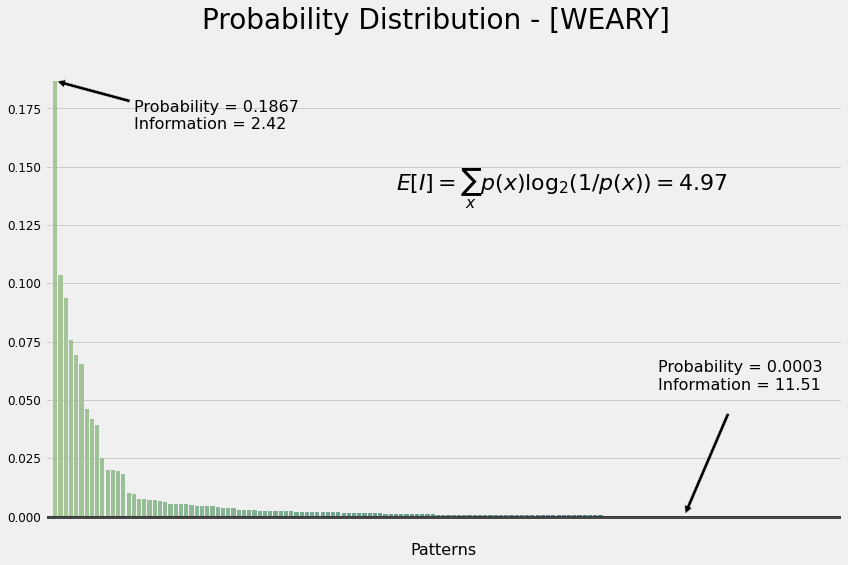

In [22]:
plot_pattern_distr(find_word, find_patt, weighted_patterns, total_words)

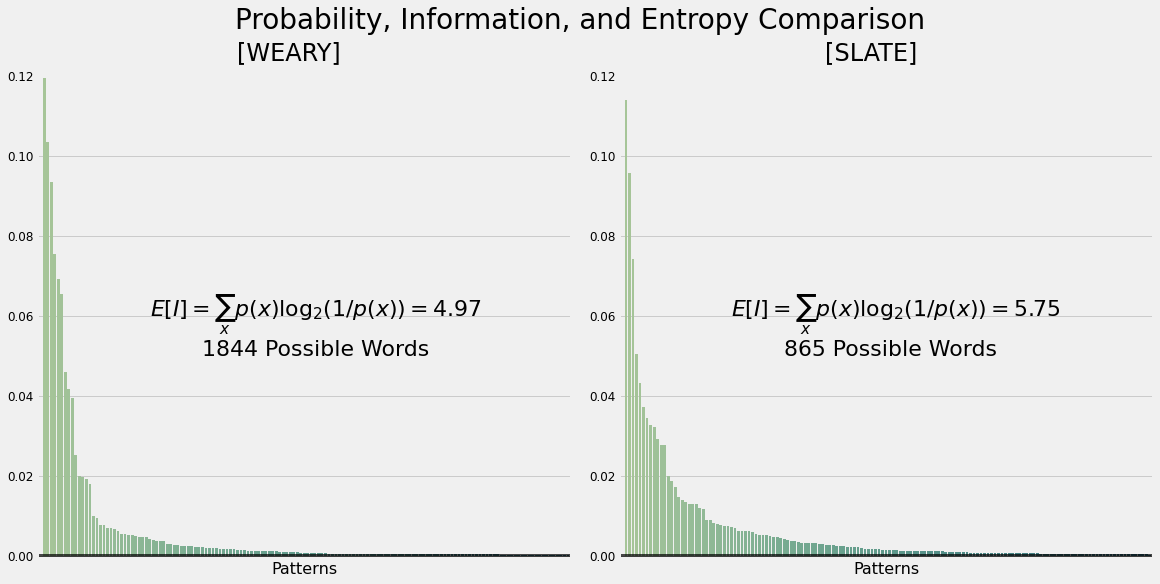

In [23]:
w3, w4 = 'WEARY', 'SLATE'
p3, p4 = 'rrrrr', 'rrrrr'
compare_words(w3, p3, w4, p4, weighted_patterns, total_words)

We can see from the above plot that the entropy values for both our test words have increased slightly. This is because we no longer are treating each word as having an equal chance of being the answer.

# Most Common Words?

So then now that we have a weighted distribution, what are the most common words used? These are ***not*** necessarily better for Wordle, but they are considered the most common 5-letter words that are in the Wordle word lists.

In [24]:
largest = nlargest(50, priorities, key = priorities.get)
top_50 = ''
for key in largest:
    top_50 += key + ' '
top_50 = top_50.rstrip()
print(f'Top 50 Most Common Words:\n{top_50}')

Top 50 Most Common Words:
WHICH THEIR THERE WOULD ABOUT COULD OTHER THESE FIRST AFTER WHERE THOSE BEING WHILE RIGHT WORLD STILL YEARS THINK NEVER AGAIN MIGHT UNDER THREE STATE GOING PLACE FOUND GREAT EVERY SINCE POWER ASKED HUMAN WATER HOUSE BASED WOMEN SMALL OFTEN ORDER POINT GIVEN UNTIL USING TABLE GROUP PRESS LARGE LATER


# Most Common First & Second Letters Combinations?

What about letter combinations in words? We saw earlier what the distribution for individual letters was, but how about pairs of letters? For example, what is the most commonly used 2-letter pair in the answer word list? Or perhaps what is the most common letter *after* a given letter? Let's make some more functions to help us with this.

In [25]:
#returns a sorted dictionary of common letters
def most_common_letter(data, keys_only=False):
    sorted_dict = {}
    if keys_only:
        return sorted(data, key = data.get, reverse = True)
    else:
        sorted_tuples = sorted(data.items(), key = lambda x:x[1], reverse = True)
        sorted_dict = {k: v for k, v in sorted_tuples}
        return sorted_dict

#returns dataframe of common letters / values
def get_common_df(answers=True):
    if answers:
        data = letter_pos_ans_counts
        tot = NUM_ANSWERS
    else:
        data = letter_pos_gue_counts
        tot = NUM_GUESSES
    
    common = {}
    keys = ['1st', '2nd', '3rd', '4th', '5th']
    for i, key in enumerate(keys):
        common[key] = most_common_letter(data[i])

        #df to show letter count in each position
        common_df = pd.DataFrame(common, columns=keys)

        #df to show frequency of each letter in each position
        common_f = common_df.apply(lambda x: x/tot)
    
    return common_df, common_f

common, common_f = get_common_df(1)
common.head()

,1st,2nd,3rd,4th,5th
S,365,16,80,171,36
C,198,40,56,150,31
B,173,16,56,24,11
T,149,77,111,139,253
P,141,61,57,50,56


We can see in the above dataframe the actual count of each letter in our answer words. **'S'** is by far the most used letter in the first position. Let's try to visualize this in a way that might be more helpful for us. Our goal is to show the most common letter in the first position, and then for each of those letters, show what the most common following letter is.

In [26]:
#returns dictionary of letter pair counts
def get_letter_pair_counts(data):
    counts = {}
    for word in data:
        if word[:2] in counts:
            counts[word[:2]] += 1
        else:
            counts[word[:2]] = 1
    return counts

#gets most common 1st letter
def get_1st(answers=True):
    if answers:
        data = answers
    else:
        data = guesses
        
    most_common_1st = {}
    
    for letter in ALPHABET:
        #get word list that starts with `letter`
        letter_words = [x for x in data if x[0]==letter]
        most_common_2nd = {}
        
        #initialize every count to 0
        for l in ALPHABET:
            most_common_2nd[letter+l] = 0
        
        #frequency table for 2nd letter, given 1st letter
        for word in letter_words:
            if letter+word[1] in most_common_2nd:
                most_common_2nd[letter+word[1]] += 1
            else:
                most_common_2nd[letter+word[1]] = 1
    
        #sorts inner dictionary - most common 2nd letter
        sorted_tuples = sorted(most_common_2nd.items(), key = lambda x:x[1], reverse = True)
        sorted_dict = {k: v for k, v in sorted_tuples}
        
        #for each letter, assign dictionary of most common 2nd letters
        most_common_1st[letter] = sorted_dict
    return most_common_1st

#get most common 2nd letters, given `letter`
def get_2nd(data, letter):
    #gets the second letter from our dictionary keys
    tot = sum(data[letter].values())
    if tot == 0:
        tot = 1
    sec_letter = [x[0][1] for x in data[letter].items()]
    sec_value = [float(x[1]/tot) for x in data[letter].items()]
    return sec_letter, sec_value

#creates dataframe of most common 2nd letters
def most_common_given_first(counts=letter_pos_ans_counts, data=answers):
    #finds most common first letter and uses it as index
    ind = list(most_common_letter(counts[0]).keys())
    df1 = pd.DataFrame(index=ind, columns=np.arange(26))
    df2 = pd.DataFrame(index=ind, columns=np.arange(26))

    #calculates most common 2nd letter, and assigns to our df
    for i in range(26):
        #there's got to be a better way to do this?
        df1.iloc[i] = get_2nd(get_1st(data), df1.index[i])[0] #string label
        df2.iloc[i] = get_2nd(get_1st(data), df2.index[i])[1] #float value
        
    return df1, df2

#plots a cool heatmap showing most common letter combinations
def plot_fancy_heatmap(data1, data2, data3, title):
    data1 = pd.DataFrame({'1st': data1['1st']},
                      index=data1.index)
    
    if isinstance(data2, pd.DataFrame):
        data2 = data2.iloc[:, np.arange(26)].astype('float64')
    else:
        data2 = data2.loc[:,['2nd', '3rd', '4th', '5th']]
        
    data1_l = pd.DataFrame()
    temp = list(data1.index)
    data1_l[0] = temp
    
    # plot it
    fig = plt.figure(figsize=(25, 12))
    fig.suptitle(f'Most Common First & Second Letter Combinations - {title}', fontsize=28, va = 'top', ha = 'center')
    
    ax0 = plt.subplot2grid((1, 3), (0, 0))
    ax0 = sns.heatmap(data1, annot=data1_l, square=True, fmt='', cmap='YlOrBr', xticklabels=False, yticklabels=False, vmin=0.0, vmax=0.2,
                      cbar_kws={'shrink': 1, 'location': 'left', 'pad':0.03, 'anchor':(10.3,0.0)})
    ax0.set_anchor('E')
    
    ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
    ax1 = sns.heatmap(data2, annot=data3, square=True, fmt = '', cmap='Blues', xticklabels=False, yticklabels=False, vmin=0.0, vmax=0.25,
                      cbar=False, cbar_kws={'shrink': 0.65, 'orientation':'horizontal', 'location':'bottom', 'pad':0.01, 'anchor':(0.0, -1.5)})
    ax1.set_anchor('W')
    plt.tight_layout()
    plt.show()

In [27]:
#dictionaries that hold counts for letter pairs
answer_pair_counts = get_letter_pair_counts(answers)
guess_pair_counts  = get_letter_pair_counts(guesses)

#dictionaries that hold sorted counts for letter pairs
ans_common_pairs = most_common_letter(answer_pair_counts)
gue_common_pairs = most_common_letter(guess_pair_counts)

#dataframes for most common letters
ans_common, ans_common_f = get_common_df(1)
gue_common, gue_common_f = get_common_df(0)

#get labels and values
ans_common_sl, ans_common_sv = most_common_given_first(letter_pos_ans_counts, answers)
gue_common_sl, gue_common_sv = most_common_given_first(letter_pos_gue_counts, guesses)

#answers
print(f'Most Common First Letter  (Answers): {ans_common.index[0]} - {ans_common.iloc[0,0]}')
print(f'Most Common Second Letter (Answers): {ans_common.index[1]} - {ans_common.iloc[1,0]}')
print(f'Number of Unique Letter Pairs (Answers): {len(ans_common_pairs)}')
print(f'Most Common Letter Pair   (Answers): {next(iter(ans_common_pairs.items()))}')

#guesses
print(f'\nMost Common First Letter  (Guesses): {gue_common.index[0]} - {gue_common.iloc[0,0]}')
print(f'Most Common Second Letter (Guesses): {gue_common.index[1]} - {gue_common.iloc[1,0]}')
print(f'Number of Unique Letter Pairs (Guesses): {len(gue_common_pairs)}')
print(f'Most Common Letter Pair   (Guesses): {next(iter(gue_common_pairs.items()))}')

Most Common First Letter  (Answers): S - 365
Most Common Second Letter (Answers): C - 198
Number of Unique Letter Pairs (Answers): 214
Most Common Letter Pair   (Answers): ('ST', 65)

Most Common First Letter  (Guesses): S - 1200
Most Common Second Letter (Guesses): B - 736
Number of Unique Letter Pairs (Guesses): 310
Most Common Letter Pair   (Guesses): ('CO', 191)


From our output above we can see some stats about our word lists. The letter **'S'** is by far the most common first letter, as several of our previous graphs and observations have shown. But what about the other letters? What is the most common letter if **'S'** is the first? The following heatmap can help us digest this wealth of information a bit easier.

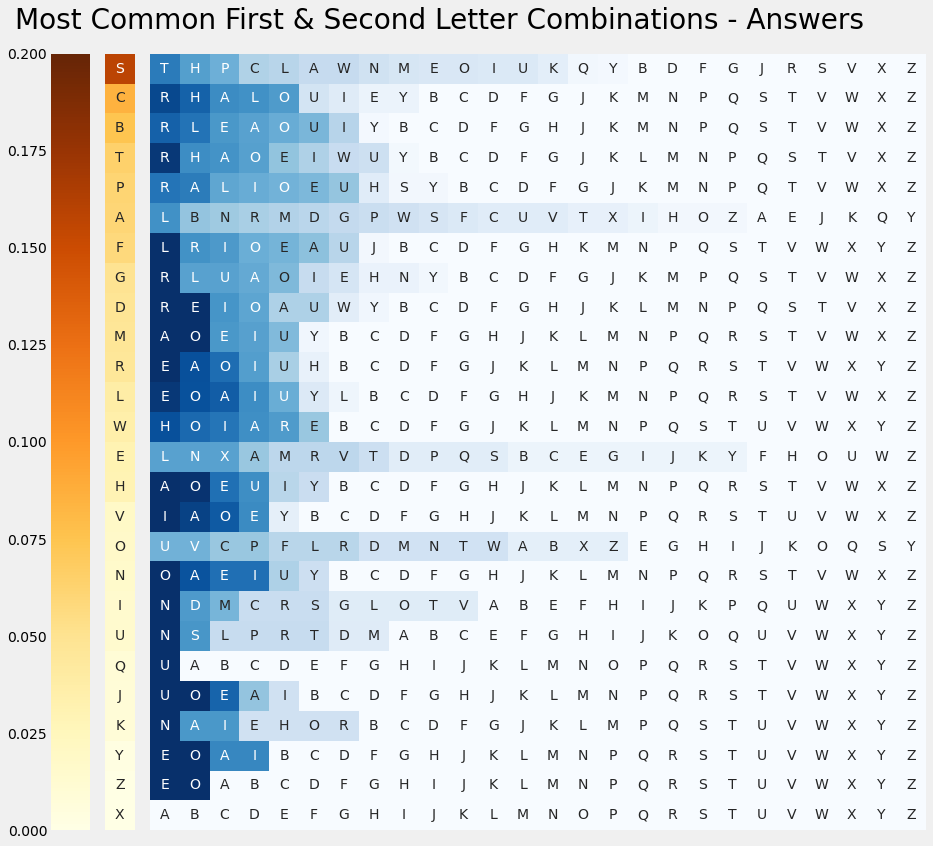

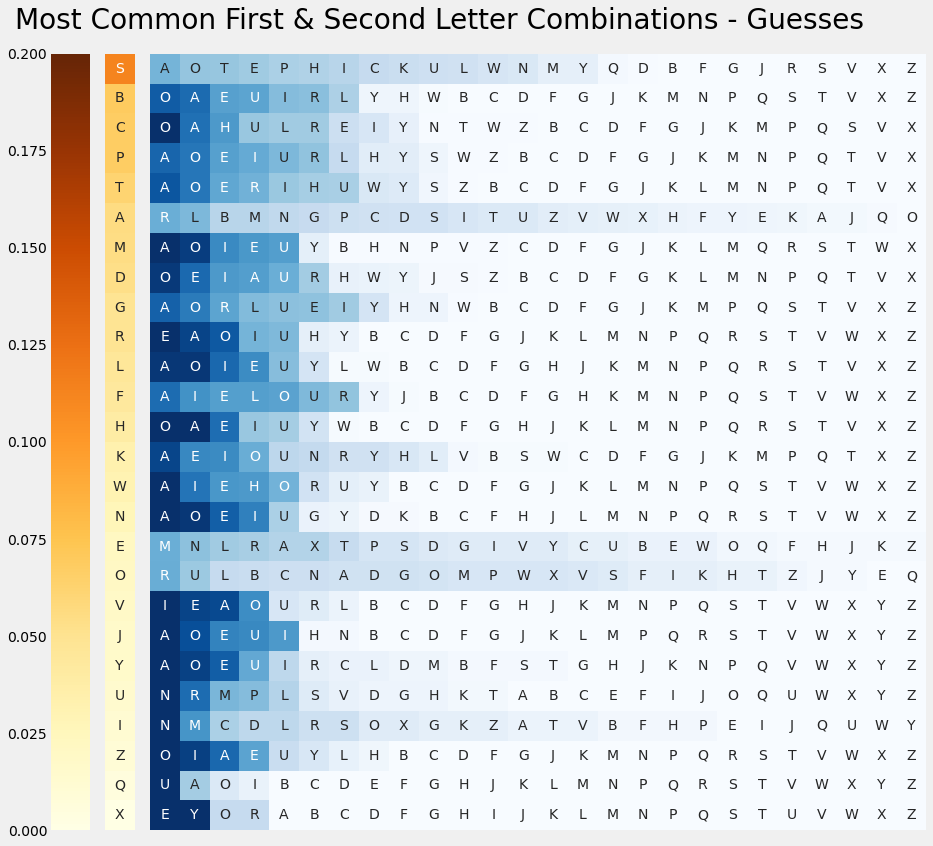

In [28]:
#plot heatmaps
plot_fancy_heatmap(ans_common_f, ans_common_sv, ans_common_sl, 'Answers')
plot_fancy_heatmap(gue_common_f, gue_common_sv, gue_common_sl, 'Guesses')

One of the most interesting things about these two heatmaps is that in our guess word list, most of the second letters are vowels while in the answer list, they are consonants. It is not clear why that is, but it might go back to the idea that the answer word list is curated, and that only commonly used words are included as answers.

# Project Goals Review

The goals for this project were the following:

* Create a way to automatically scrape the Wordle website and extract the word lists - **DONE**
* Create aesthetically pleasing visualizations for things such as frequency or distribution of letters, etc.  - **DONE**
* Explore any possible correlation between individual letters and their positioning in the target word  - **DONE**
* Find the most common first letter, as well as the most common follow-up letter  - **DONE**

# Conclusion

In this exhaustive analysis of Wordle, we looked at several key aspects of the game:
* Letter Distributions
    * **R, S, T, L, N** are the most common consonants in both sets
    * **E** is the most common vowel in both sets
    * **V, Z, X, Q, J** are the least common letters in both sets
* Position Distributions
    * **S** is the most common first letter in both sets
    * **E** is the most common last letter for answers, but **S** is the most common last letter for the guesses
* The Interesting Absence of Plural Words
    * There are no plurals ending with **S** in the answer list
    * There are many plurals ending with **S** in the guess list
* Letter Probability and Correlation
    * **2<sup>nd</sup>** and **3<sup>rd</sup>** letters have higher probability of being a vowel
    * The letter probabilities seem more evenly distributed for answer list than for the guess list (more varied words in answers, many similar words in guesses)
* Information and Entropy
    * The higher the entropy, the more surprising the outcome and the more useful information we can get from the result.
    * More common outcomes = less information, lower entropy
    * Rarer outcomes = more information, higher entropy
    
# Further Steps

* Flesh this out even further and create a full-blown Wordle simulator.
* Improve and/or refine plots